In [1]:
# --- Standard libraries
import os
import copy
import re
import json
import codecs
import numpy as np
import pandas as pd
from natsort import natsorted
from scipy.signal import find_peaks
# --- Bokeh
from bokeh.io import output_notebook, show, export_png, export_svg
from bokeh.plotting import figure
output_notebook()
# --- ASE
from ase.io import read
# --- RDKit
import rdkit
from rdkit import Chem
from rdkit.Chem.rdmolfiles import MolFromXYZFile
from rdkit.Chem import rdDetermineBonds
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.8
IPythonConsole.molSize = 400,400
rdkit.__version__

Loading BokehJS ...

'2023.09.5'

### Code functions

In [2]:
def create_mol_from_xyz(path):

    '''
    Take in the path of a .xyz file and use
    RDKit to create a mol object and SMILES string
    '''

    # --- Read in and create RDkit mol variable
    raw_mol = MolFromXYZFile(path)
    rdDetermineBonds.DetermineBonds(raw_mol)
    #mol = Chem.RemoveAllHs(raw_mol)
    mol = raw_mol
    Chem.RemoveStereochemistry(mol)

    xyz_dict = {}
    ase_go = read(path)
    pos = ase_go.get_positions()

    # --- RDKit index given by the order in the XYZ file but
    # --- this changes when reading the SMILES string to a new atom
    # --- indexing.
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetAtomMapNum(atom.GetIdx())
        xyz_dict[atom.GetIdx()] = list(pos[i])

    # --- Create SMILES and SMARTS strings
    smi = Chem.MolToSmiles(mol)

    # --- Load a new RDKit mol to get new RDKit atom indexes
    new_mol = Chem.MolFromSmiles(smi)
    # --- Create dictionaries to store information
    idx_dict = {}
    map_num = {}
    new_xyz = {}

    # --- Loop over all atoms in the molecule
    for atom in new_mol.GetAtoms():
        # --- Create dictionary linking mapnum to atom index
        map_num[atom.GetAtomMapNum()] = atom

    # --- Sort the dictionary in numerical order
    sort_map = sorted(map_num)

    # --- Loop over all atoms in the molecule with respect to map number
    for num in sort_map:
        # --- If atom is a carbon
        if map_num[num].GetAtomicNum() == 6:
            # --- Get the RDkit atom index and store into new dictionary
            rd_idx = map_num[num].GetIdx()
            idx_dict[num] = rd_idx#, xyz_dict[num], map_num[num].GetAtomicNum()

        rdk_idx = map_num[num].GetIdx()
        new_xyz[rdk_idx] = num, xyz_dict[num], map_num[num].GetAtomicNum()
    
    z = []
    pos = np.zeros([len(new_xyz), 3])

    for i in range(len(new_xyz)):
        z_temp = new_xyz[i][2]
        z.append(z_temp)

        for x in range(3):
            pos_temp = new_xyz[i][1]
            pos[i, x] = pos_temp[x]

    return new_mol, smi, idx_dict, pos, z

In [3]:
def count_atoms(mol, atomic_num):

    '''
    Count the number of a specific atom in 
    a molecule using RDKit
    '''

    num_atoms = 0
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == atomic_num:
            num_atoms += 1
    
    return num_atoms

In [4]:
def create_spec_dict(main_dir):

    '''
    Create a python dictionary for a molecule with atom indexes
    as keys and the individual spectrum as the value
    '''

    # --- Create x-axis array to plot data with
    x = np.linspace(280, 320, num=400, endpoint=True)
    sigma = 0.6

    # --- List all the possible xyz files
    xyz_files = [f for f in os.listdir(main_dir) if os.path.isfile(os.path.join(main_dir, f))]

    # --- Search for correct optimised XYZ file
    pattern = r'OPT_[\w]+\.xyz$'

    for filename in xyz_files:
        if re.match(pattern, filename):
            xyz_name = filename
            break

    # --- Set a variable for the chosen xyz file
    xyz_path = main_dir + '/' + xyz_name

    # --- Call function to rearrange xyz file atom order
    rearrange_xyz(main_dir, xyz_name)

    # --- Call function to create RDKit mol variable
    mol, smiles, idx_dict, pos, z = create_mol_from_xyz(xyz_path)

    # --- Get all individual atom directories for molecule
    loc_dirs = [os.path.join(main_dir, d) for d in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, d))]

    # --- Sort directories in numerical order
    sort_dirs = natsorted(loc_dirs)

    spec_dict = {}
    # maxx = 0

    # --- Loop through all atom directories
    for i in range(len(loc_dirs)):
        loc_dir = sort_dirs[i]
        # --- Loop through and get all files in atom directory
        loc_files = [f for f in os.listdir(loc_dir) if os.path.isfile(os.path.join(loc_dir, f))]

        # --- Loop through all files in directory
        for filename in loc_files:
            # --- Find spectrum .abs.stk file and read data
            if filename.endswith('.abs.stk'):
                spec_df = pd.read_csv(loc_dir + '/' + filename, sep='\s+', header=None, names=['Peaks', 'Strength'])
                # --- Extract the photon energy and oscilator strength
                energies = spec_df['Peaks']
                osc = spec_df['Strength']
                # --- Call function to broaden spectrum
                gE = broaden_spectrum(energies, osc, x, sigma)

                max_val = find_peaks(gE)
                begin = max_val[0][0] - 15
                end = max_val[0][0] + 185
                gE = gE[begin:end]
                # top = max(gE)
                # if top > maxx:
                #     maxx = top
                
                #print(len(gE))
                #norm_spec = 1.0 * (gE / 6471.923222767645)
                norm_spec = [1.0 * (e / 4132.901376509333) for e in gE]
                #print(norm_spec.shape)
                # --- Add to dictionary with RDKit index
                spec_dict[i] = norm_spec

    return mol, spec_dict, smiles, pos, z

### Start code

In [5]:
# --- Path to main folder where all the data is
data_path = '../GNN_XAS_Node/raw_data/coronene_rearranged/OPT_output'
# --- Create a list with the path of all the different molecule folders
subdirs = [os.path.join(data_path, d) for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

# --- Number of molecules in the data set
print(len(subdirs))
# --- List of paths to all the different molecules
print(subdirs)

317
['../GNN_XAS_Node/raw_data/coronene_rearranged/OPT_output\\R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_3_2', '../GNN_XAS_Node/raw_data/coronene_rearranged/OPT_output\\R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_1_1', '../GNN_XAS_Node/raw_data/coronene_rearranged/OPT_output\\R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_4_1', '../GNN_XAS_Node/raw_data/coronene_rearranged/OPT_output\\R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_2_ieEPOXY_1_0', '../GNN_XAS_Node/raw_data/coronene_rearranged/OPT_output\\R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_3_ieEPOXY_1_2', '../GNN_XAS_Node/raw_data/coronene_rearranged/OPT_output\\R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_1_2', '../GNN_XAS_Node/raw_data/coronene_rearranged/OPT_output\\R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_4_0', '../GNN_XAS_Node/raw_data/coronene_rearranged/OPT_output\\R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_

In [6]:
mol_name = []
# --- Split up into the directory path and list of all the folder/molecule names
for subdir in subdirs:
    dir_path, path = os.path.split(subdir)
    mol_name.append(path)

print(len(mol_name))
# --- List of all the molecule names
print(mol_name)

317
['R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_3_2', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_1_1', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_4_1', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_2_ieEPOXY_1_0', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_3_ieEPOXY_1_2', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_1_2', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_4_0', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_2_ieEPOXY_0_0', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_2_ieEPOXY_1_2', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_2_iEPOXY_3_ieEPOXY_0_2', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_0_ieEPOXY_1_1', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_0', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_1', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_1_2', '

In [7]:
print(subdir)

../GNN_XAS_Node/raw_data/coronene_rearranged/OPT_output\R_eOH_4_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_0_1


In [47]:
def get_xyz_file(directory):
    '''
    
    '''
    # --- Get a list of all the files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    # --- Pattern to find the xyz file
    pattern = r'OPT_[\w]+\.xyz$'

    for file in files:
        if re.match(pattern, file):
            xyz_name = file
            break

    xyz_path = os.path.join(directory, xyz_name)
    return xyz_path

def rearrange_xyz(file_path):

    '''
    Function that rearranges the given .xyz file to move all the
    oxygen and hydrogen atoms to the bottom of the file
    '''

    # --- Open the original .xyz file and parse the lines with
    # --- O and H coordinates to lists
    with open(file_path, 'r') as fr:
        lines = fr.readlines()
        o_lines = []
        h_lines = []

        for line in lines:
            if line.startswith('  O'):
                o_lines.append(line)
            elif line.startswith('  H'):
                h_lines.append(line)

        # --- Open the .xyz file to write
        with open(file_path, 'w') as fw:

            # --- Write all lines that are not O or H coordinates
            for line in lines:
                if line.startswith('  H'):
                    pass
                elif line.startswith('  O'):
                    pass
                else:
                    fw.write(line)
        
            # --- Write O coordinates
            for x in o_lines:
                fw.write(x)

            # --- Write H coordinates
            for y in h_lines:
                fw.write(y)

def create_mol(file_path):
    '''
    
    '''
    # --- Read in and create RDkit mol variable
    mol = MolFromXYZFile(file_path)
    rdDetermineBonds.DetermineBonds(mol)
    Chem.RemoveStereochemistry(mol)
    
    # --- Get the xyz coordinates of the molecule
    ase_go = read(file_path)
    pos = ase_go.get_positions()

    # --- Create a dictionary of the atom indexing
    xyz_dict = {}
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetAtomMapNum(atom.GetIdx())
        xyz_dict[atom.GetIdx()] = list(pos[i])

    # --- The atom indexing changes 
    smiles = Chem.MolToSmiles(mol)
    new_mol = Chem.MolFromSmiles(smiles)
    map_num = {}
    for atom in new_mol.GetAtoms():
        map_num[atom.GetAtomMapNum()] = atom

    # --- Get a ordered list of the atom map numbers
    sort_map = sorted(map_num)

    idx_dict = {}
    for num in sort_map:
        if map_num[num].GetAtomicNum() == 6:
            idx_dict[num] = map_num[num].GetIdx()

    return new_mol, smiles, idx_dict

def broaden_spectrum(E, osc):
    '''
    Take the delta peaks of a XAS spectrum and applies
    a Gaussian broadening scheme
    '''

    x = np.linspace(280, 300, num=200, endpoint=True)
    sigma = 0.6
    gE = []

    # --- Apply Gaussian broadening
    for Ei in x:
        tot = 0
        for Ej, os in zip(E, osc):
            tot += os * np.exp(-((((Ej - Ei) / sigma) ** 2)))
            #norm_tot = tot / 6471.923222767645
        gE.append(tot)
    
    return gE

In [49]:
# --- Create python dictionaries
final_dict = {}
mol_dict = {}
smiles_dict = {}

# --- Molecule counter
mol_num = 1

# --- Loop through all the molecule directories
for subdir in subdirs:
    dir_path, mol_name = os.path.split(subdir)
    print(f'Current mol no {mol_num}: {mol_name}')
    mol_num += 1

    # --- Get 
    xyz_path = get_xyz_file(subdir)
    # --- Rearrage the xyz file 
    rearrange_xyz(xyz_path)
    # ---
    mol, smiles, id_dict = create_mol(xyz_path)

    # --- Get all the individual atom directories for molecule
    atom_direcs = [os.path.join(subdir, d) for d in os.listdir(subdir) if os.path.isdir(os.path.join(subdir, d))]
    # --- Sort directories in numerical order
    sorted_direcs = natsorted(atom_direcs)
    spec_dict = {}
    # ---
    for i in range(len(sorted_direcs)):
        atom_dir = sorted_direcs[i]
        # --- Get a list of all the files in the directory
        atom_files = [f for f in os.listdir(atom_dir) if os.path.isfile(os.path.join(atom_dir, f))]

        # ---
        for file in atom_files:
            if file.endswith('abs.stk'):
                spec_df = pd.read_csv(os.path.join(atom_dir, file), sep='\s+', header=None,
                                      names=['Peaks', 'Strength'])
                # --- Extract the photon energy and oscilator strength
                energies, osc = spec_df['Peaks'], spec_df['Strength']
                # --- Broaden the spectra
                gE = broaden_spectrum(energies, osc)

                # --- Shift the peaks to the same start point
                # max_val = find_peaks(gE)
                # begin = max_val[0][0] - 15
                # end = max_val[0][0] + 185
                # gE = gE[begin:end]
                # top = max(gE)
                # if top > maxx:
                #     maxx = top
                
                # --- Normalise the spectra to 1
                # norm_spec = 1.0 * (gE / 6471.923222767645)
                norm_spec = [1.0 * (e / 4132.901376509333) for e in gE]

                spec_dict[id_dict[i]] = norm_spec
    
    final_dict[mol_name] = spec_dict
    mol_dict[mol_name] = smiles         

    # # --- Call function to create spectrum dictionary
    # mol, spec_list, smiles, pos, z = create_spec_dict(subdir)
    # num_carbons = count_atoms(mol, 6)

    # # --- Sanity check number of carbons in mol matches
    # # --- the number of spectra, if so create dictionaries
    # if len(spec_list.keys()) == num_carbons:
    #     spec_dict[mol_name] = spec_list
    #     mol_dict[mol_name] = smiles, pos.tolist(), z
    # else:
    #     print('Molecule invalid:', subdir)


Current mol no 1: R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_3_2
Current mol no 2: R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_1_1
Current mol no 3: R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_4_1
Current mol no 4: R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_2_ieEPOXY_1_0
Current mol no 5: R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_3_ieEPOXY_1_2
Current mol no 6: R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_1_2
Current mol no 7: R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_4_0
Current mol no 8: R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_2_ieEPOXY_0_0
Current mol no 9: R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_2_ieEPOXY_1_2
Current mol no 10: R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_2_iEPOXY_3_ieEPOXY_0_2
Current mol no 11: R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_0_ieEPOXY_1_1
Current mol no 12: R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_

In [50]:
# Combine the mol and spectra dictionaries into one variable
data = []

data.append(mol_dict)
data.append(final_dict)

In [51]:
# --- Save the data into a json file
json.dump(data, codecs.open('raw/data_coronene_rdkit_idx.json', 'w', encoding='utf-8'),
          separators=(',', ':'),
          sort_keys=True,
          indent=4)

### Check saved data

In [52]:
with open('raw/data_coronene_rdkit_idx.json', 'r') as j_file:
    data = json.load(j_file)

In [53]:
# --- Load all the molecule names from keys of first dictionary
keys = []

for i in data[0].keys():
    keys.append(i)

print(keys)

['R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_3_2', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_1_1', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_4_1', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_2_ieEPOXY_1_0', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_3_ieEPOXY_1_2', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_1_2', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_4_0', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_2_ieEPOXY_0_0', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_2_ieEPOXY_1_2', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_2_iEPOXY_3_ieEPOXY_0_2', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_0_ieEPOXY_1_1', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_0', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_1', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_1_2', 'R_eO

In [66]:
# --- View the data stored in the second dictionary for a given key
mol_name = keys[200]
#mol_name = 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_3_2'

print(mol_name)
print(len(data[1][mol_name].keys()))
print(data[1][mol_name].keys())

R_eOH_1_eCOOH__0_eEPOXY_0_eCHO_3_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_0_2
27
dict_keys(['0', '1', '2', '3', '4', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '22', '23', '25', '26', '28', '29', '30'])


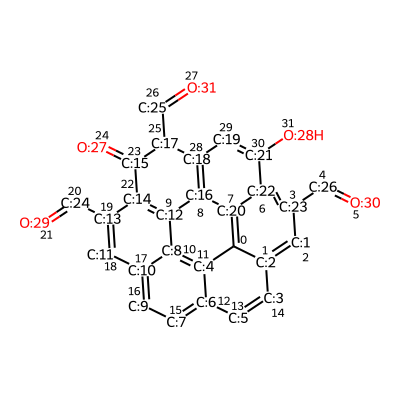

In [67]:
# --- Create RDKit mol from SMILES
mol = Chem.MolFromSmiles(data[0][mol_name])
mol

In [72]:
# --- Set up Bokeh plot settings
p = figure(
    x_axis_label = 'Photon Energy (eV)',
    y_axis_label = 'arb. units',
    x_range = (280, 300),
    width = 500, height = 500,
    outline_line_color = 'black', outline_line_width = 2
)

p.toolbar.logo = None
p.toolbar_location = None
p.min_border = 25

# --- x-axis settings
p.xaxis.ticker.desired_num_ticks = 3
p.xaxis.axis_label_text_font_size = '24px'
p.xaxis.major_label_text_font_size = '24px'
p.xaxis.major_tick_in = 0
p.xaxis.major_tick_out = 10
p.xaxis.minor_tick_out = 6
p.xaxis.major_tick_line_width = 2
p.xaxis.minor_tick_line_width = 2
p.xaxis.major_tick_line_color = 'black'
p.xaxis.minor_tick_line_color = 'black'
# --- y-axis settings
p.yaxis.axis_label_text_font_size = '24px'
p.yaxis.major_tick_line_color = None
p.yaxis.minor_tick_line_color = None
p.yaxis.major_label_text_color = None
# --- grid settings
p.grid.grid_line_color = 'grey'
p.grid.grid_line_alpha = 0.3
p.grid.grid_line_width = 1.5
p.grid.grid_line_dash = "dashed"

In [73]:
# --- Plot similar spectra of similar chemical environments
# --- to check if dictionary is right
x = np.linspace(280, 300, 200)
p.line(x, data[1][mol_name]['20'], line_width=3, line_color='blue')
p.line(x, data[1][mol_name]['26'], line_width=3, line_color='red')
show(p)

In [ ]:
export_png(p, filename='atom_spectra.png', width=500, height=500)

'd:\\github\\GO_molecule_GNN\\atom_spectra.png'

In [135]:
file = '../GNN_XAS_Node/raw_data/coronene_rearranged/OPT_output/R_eOH_2_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_0_0/OPT_R_eOH_2_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_0_0.xyz'

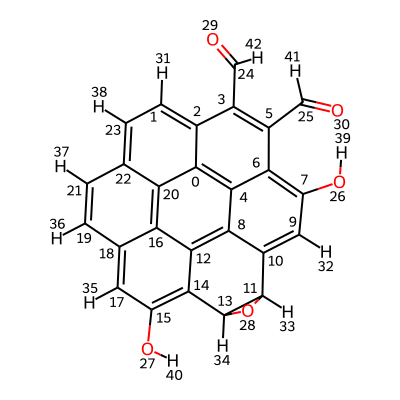

In [136]:
raw_mol = MolFromXYZFile(file)
rdDetermineBonds.DetermineBonds(raw_mol)
Chem.RemoveStereochemistry(raw_mol)
raw_mol

In [137]:
ase_go = read(file)
pos = ase_go.get_positions()
pos

array([[ 0.07998842,  1.24549241, -0.16398114],
       [-1.11953604,  3.41208487, -0.304955  ],
       [ 0.10871408,  2.67820874, -0.29658147],
       [ 1.38134354,  3.32798023, -0.43479372],
       [ 1.30081025,  0.47531921, -0.13965858],
       [ 2.59462456,  2.60238423, -0.33742997],
       [ 2.59062855,  1.14531358, -0.22954421],
       [ 3.77682809,  0.31832661, -0.24878732],
       [ 1.21003015, -0.95305203, -0.01992841],
       [ 3.64002674, -1.08376772, -0.16674684],
       [ 2.41057704, -1.71273823, -0.02125571],
       [ 2.3747487 , -3.18745615,  0.13862769],
       [-0.07852943, -1.62525542,  0.05085999],
       [ 1.05463678, -3.86298968,  0.20663917],
       [-0.17425142, -3.04186296,  0.12403563],
       [-1.44804227, -3.66934837,  0.17472603],
       [-1.27243711, -0.84528545,  0.00891953],
       [-2.62017673, -2.90665012,  0.12698329],
       [-2.55345666, -1.50033049,  0.05007667],
       [-3.74330271, -0.69735429,  0.02207522],
       [-1.19480108,  0.58229701, -0.083

In [141]:
xyz_dict = {}
for i, atom in enumerate(raw_mol.GetAtoms()):
    atom.SetAtomMapNum(atom.GetIdx())
    xyz_dict[atom.GetIdx()] = list(pos[i])

In [142]:
xyz_dict

{0: [0.07998841530026, 1.24549241393454, -0.16398114479497],
 1: [-1.11953603815, 3.41208487363282, -0.30495500353855],
 2: [0.108714083447, 2.67820874480769, -0.29658146533034],
 3: [1.38134353957558, 3.32798022677456, -0.43479372217952],
 4: [1.30081024926138, 0.47531921119308, -0.13965858048541],
 5: [2.5946245614029, 2.60238422675603, -0.33742997247084],
 6: [2.59062855052049, 1.14531358211767, -0.2295442093781],
 7: [3.77682808709252, 0.31832661229429, -0.248787322895],
 8: [1.21003015237044, -0.95305203207705, -0.01992841475747],
 9: [3.64002674496495, -1.0837677159885, -0.16674683653516],
 10: [2.41057703868928, -1.71273823051323, -0.02125571096523],
 11: [2.37474870244395, -3.18745614749732, 0.13862768796452],
 12: [-0.07852943061697, -1.62525542389094, 0.05085998833702],
 13: [1.05463677808292, -3.862989680076, 0.20663916654708],
 14: [-0.17425142265788, -3.04186295637212, 0.12403562653937],
 15: [-1.44804226578456, -3.66934836871666, 0.17472602896324],
 16: [-1.27243710770636

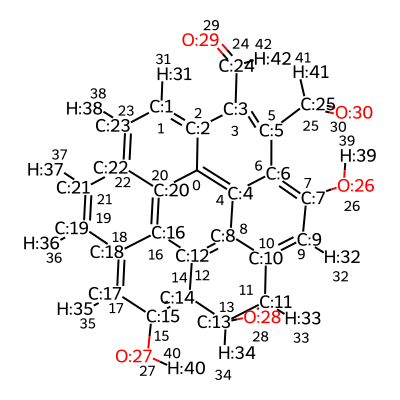

In [143]:
raw_mol

In [144]:
smiles = Chem.MolToSmiles(raw_mol)
smiles

'c12[c:2]3[c:1]([H:31])[c:23]([H:38])[c:22]4[c:20]1[c:16]1[c:12]5[c:8]6[c:4]2[c:6]([c:5]([C:25](=[O:30])[H:41])[c:3]3[C:24](=[O:29])[H:42])[c:7]([O:26][H:39])[c:9]([H:32])[c:10]6[C:11]2([H:33])[C:13]([H:34])([c:14]5[c:15]([O:27][H:40])[c:17]([H:35])[c:18]1[c:19]([H:36])[c:21]4[H:37])[O:28]2'

In [146]:
new_mol = Chem.MolFromSmiles(smiles)

In [147]:
map_num = {}
for atom in new_mol.GetAtoms():
    map_num[atom.GetAtomMapNum()] = atom

In [148]:
map_num

{0: <rdkit.Chem.rdchem.Atom at 0x1ed3dd44190>,
 2: <rdkit.Chem.rdchem.Atom at 0x1ed3dadd580>,
 1: <rdkit.Chem.rdchem.Atom at 0x1ed3dd44200>,
 23: <rdkit.Chem.rdchem.Atom at 0x1ed3dd44270>,
 22: <rdkit.Chem.rdchem.Atom at 0x1ed3dd442e0>,
 20: <rdkit.Chem.rdchem.Atom at 0x1ed3dd44350>,
 16: <rdkit.Chem.rdchem.Atom at 0x1ed3dd443c0>,
 12: <rdkit.Chem.rdchem.Atom at 0x1ed3dd44430>,
 8: <rdkit.Chem.rdchem.Atom at 0x1ed3dd444a0>,
 4: <rdkit.Chem.rdchem.Atom at 0x1ed3dd44510>,
 6: <rdkit.Chem.rdchem.Atom at 0x1ed3dd44580>,
 5: <rdkit.Chem.rdchem.Atom at 0x1ed3dd445f0>,
 25: <rdkit.Chem.rdchem.Atom at 0x1ed3dd44660>,
 30: <rdkit.Chem.rdchem.Atom at 0x1ed3dd446d0>,
 3: <rdkit.Chem.rdchem.Atom at 0x1ed3dd44740>,
 24: <rdkit.Chem.rdchem.Atom at 0x1ed3dd447b0>,
 29: <rdkit.Chem.rdchem.Atom at 0x1ed3dd44820>,
 7: <rdkit.Chem.rdchem.Atom at 0x1ed3dd44890>,
 26: <rdkit.Chem.rdchem.Atom at 0x1ed3dd44900>,
 9: <rdkit.Chem.rdchem.Atom at 0x1ed3dd44970>,
 10: <rdkit.Chem.rdchem.Atom at 0x1ed3dd449e0>,
 1

In [149]:
sort_map = sorted(map_num)
sort_map

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]

In [157]:
idx_dict = {}
new_xyz = {}
for num in sort_map:
    if map_num[num].GetAtomicNum() == 6:
        rd_idx = map_num[num].GetIdx()
        idx_dict[num] = rd_idx

    rdk_idx = map_num[num].GetIdx()
    new_xyz[rdk_idx] = num, xyz_dict[num], map_num[num].GetAtomicNum()

In [158]:
new_xyz

{0: (0, [0.07998841530026, 1.24549241393454, -0.16398114479497], 6),
 2: (1, [-1.11953603815, 3.41208487363282, -0.30495500353855], 6),
 1: (2, [0.108714083447, 2.67820874480769, -0.29658146533034], 6),
 14: (3, [1.38134353957558, 3.32798022677456, -0.43479372217952], 6),
 9: (4, [1.30081024926138, 0.47531921119308, -0.13965858048541], 6),
 11: (5, [2.5946245614029, 2.60238422675603, -0.33742997247084], 6),
 10: (6, [2.59062855052049, 1.14531358211767, -0.2295442093781], 6),
 17: (7, [3.77682808709252, 0.31832661229429, -0.248787322895], 6),
 8: (8, [1.21003015237044, -0.95305203207705, -0.01992841475747], 6),
 19: (9, [3.64002674496495, -1.0837677159885, -0.16674683653516], 6),
 20: (10, [2.41057703868928, -1.71273823051323, -0.02125571096523], 6),
 21: (11, [2.37474870244395, -3.18745614749732, 0.13862768796452], 6),
 7: (12, [-0.07852943061697, -1.62525542389094, 0.05085998833702], 6),
 22: (13, [1.05463677808292, -3.862989680076, 0.20663916654708], 6),
 23: (14, [-0.17425142265788,

In [162]:
z = []
pos = np.zeros([len(new_xyz), 3])
for i in range(len(new_xyz)):
    z_temp = new_xyz[1][2]
    z.append(z_temp)

    for x in range(3):
        pos_temp = new_xyz[i][1]
        pos[i, x] = (pos_temp[x])

In [164]:
pos

array([[ 0.07998842,  1.24549241, -0.16398114],
       [ 0.10871408,  2.67820874, -0.29658147],
       [-1.11953604,  3.41208487, -0.304955  ],
       [-2.33425277,  2.76368073, -0.21159782],
       [-2.40740325,  1.34796284, -0.11279564],
       [-1.19480108,  0.58229701, -0.08309429],
       [-1.27243711, -0.84528545,  0.00891953],
       [-0.07852943, -1.62525542,  0.05085999],
       [ 1.21003015, -0.95305203, -0.01992841],
       [ 1.30081025,  0.47531921, -0.13965858],
       [ 2.59062855,  1.14531358, -0.22954421],
       [ 2.59462456,  2.60238423, -0.33742997],
       [ 3.76593275,  3.48666775, -0.21426745],
       [ 4.96274175,  3.20504679, -0.06037656],
       [ 1.38134354,  3.32798023, -0.43479372],
       [ 1.42553951,  4.78426645, -0.83326655],
       [ 0.66150486,  5.65619149, -0.4529148 ],
       [ 3.77682809,  0.31832661, -0.24878732],
       [ 5.03300978,  0.73927207, -0.3623296 ],
       [ 3.64002674, -1.08376772, -0.16674684],
       [ 2.41057704, -1.71273823, -0.021